# Word2Vec

The Word2Vec technique is a method for obtaining and word embeding suitable for natural language processing, such as finding synonyms, making analogies and suggesting missing words for a sentence. It uses a neural network to learn from a large text (or corpus) am build a n-dimensional space containing one vector for each word on the training vocabulary.

This technique is relatively recent, being first published by a team of Google researches in 2013. The two main algorithms applied are skipgram and cbow. In both cases, we use a set of hyperparams, such as number of features in the word embeding (or the dimensionality of each word vector), the number of epochs and the size of our context window, to define the way our language model will be trained.

The objective of this notebook, is to explore how the variation of these hyperparameters will affect the accuracy of our model. The following implementation was made using gensim. It covers the training and validation of various models, however, **it does not cover any kind of sophisticated text lemmatization**, since we are using an already noralized corpus. Needless to say, that is not the real word scenario in most cases, therefore, any pratical implementation of Word2Vec should take this into account.

In [44]:
import math
import sys
import numpy as np
import pandas as pd
import itertools
from time import time, sleep
import multiprocessing

# File management
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from os import path, remove, mkdir

# NLP
from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus
from gensim.test.utils import datapath
import spacy
import nltk
nltk.download('stopwords')

# Data analisis
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

try:
    mkdir('models')
except:
    pass

[nltk_data] Downloading package stopwords to /Users/eem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def progress_bar(done = 0, total = 100):
    progress = 20*(done/total)
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('='*math.floor(progress), 5*progress))
    sys.stdout.flush()
    if done == total:
        print('')

## Downloading the corpus

The first thing we got to do is to download the corpus we will be using to train our model. Here we will use a text of lowercase and unponctuated englih words supported by gensim as standard. The file is 100MB long, so it wont be included on the repository, nevertheless, the code bellow should perform the propper configuration.

In [3]:
corpus_uri = 'http://mattmahoney.net/dc/text8.zip'
target_name = './corpus.txt'
corpus_language = 'english'

if not path.exists(target_name):
    try:
        resp = urlopen(corpus_uri)
        file = ZipFile(BytesIO(resp.read()))

        target_file = open(target_name, 'w')
        for line in file.open(file.namelist()[0]).readlines():
            target_file.write(line.decode('utf-8'))
        target_file.close()
    except:
        if path.exists(target_name):
            remove(target_name)
            
corpus = open(target_name, 'r')
content = corpus.read()
print(content[:1024])

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic instituti

## Pre processing

Our text is mostly normalized, so all we are going to do is break the text into sentences (using gensim standard support) and remove stopwords using the natural language toolkit library group of english stopwords.

In [4]:
# Split text into sentences
stopwords = nltk.corpus.stopwords.words('english')
sentences = list(itertools.islice(Text8Corpus(target_name),None))
sentences = [[word for word in sentence if word not in stopwords] for sentence in sentences]

## Creating and training the language model

The following functions are used for building the vocabulary and training our models. We will have a set of 108 combinations of parametres for each algorithm, therefore we will have to train 216 models. Each model takes a few minutes to train so it would be a very time consuming process to run each time. Gladly, gensim allows us to save our models into files, so we only have to train the models once.

The code will then verify if for a given set of hyperparameters a model was already created, if so, it will simply load the model from its file.

In [5]:
def build_vocabulary(model, sentences):
    t = time()
    model.build_vocab(sentences, progress_per=10000)
    return time() - t

def train(model, sentences, epochs, corpus_size):
    t = time()
    model.train(sentences, total_examples=corpus_size, epochs=epochs, report_delay=1)
    return time() - t

def build_model(sentences, min_count, window, vector_size, alpha, epochs, sg, corpus_size, model_name):
    cores = multiprocessing.cpu_count()
    model = Word2Vec(min_count=min_count, window=window, vector_size=vector_size, alpha=0.001, workers=cores-1, sg=sg)
    corpus_size = model.corpus_count if corpus_size == 0 else corpus_size
    
    t = 0
    t = t + build_vocabulary(model, sentences)
    t = t + train(model, sentences, epochs, corpus_size)
    
    model.save(model_name)
    return t
    
def get_model_name(sg, window, vector_size, epochs, corpus_size, min_count):
    return "./models/{sg}-{window}-{vector_size}-{epochs}-{corpus_size}-{min_count}.model".format(
        sg = 'skipgram' if sg == 1 else 'cbow',
        window = window,
        vector_size = vector_size,
        epochs = epochs,
        corpus_size = corpus_size,
        min_count = min_count
    )
    
def build_if_not_exists(sentences, sg=1, window=2, vector_size=100, epochs=30, corpus_size=0, min_count=50):
    model_name = get_model_name(sg, window, vector_size, epochs, corpus_size, min_count)
    
    if not path.isfile(model_name):
        return build_model(
            sentences = sentences,
            min_count = min_count,
            window = window,
            vector_size = vector_size,
            alpha = 0.001,
            epochs = epochs,
            sg = sg,
            corpus_size = corpus_size,
            model_name = model_name
        )
    else:
        return 0
    
def get_model(corpus_size, sg=1, window=2, vector_size=100, epochs=30, min_count=50):
    model_name = get_model_name(sg, window, vector_size, epochs, corpus_size, min_count)
    
    if path.isfile(model_name):
        return Word2Vec.load(model_name).wv
    else:
        raise KeyError('Model not trained')

### Parameters

For the hyperparameters to be tunned we will have:

1. vector_sizes, wich indicates the number of features in each word embeding of the model
2. windows, which reffers to the size of the context use to evaluate the sentences during training
3. min_counts, which is the number of times a word must apear in the corpus to be present on the vocabulary
4. corpus_sizes, which is the number of sentences from our corpus that will be considered for training
5. the number of epochs performed during training

each one of the parameters will have three values and each value will be evenly permutated generating 108 combinations.

In [6]:
vector_sizes = [50, 300]
windows = [2, 5, 10]
min_counts = [10, 30, 50]
corpus_sizes = [math.floor(len(sentences)*.5), len(sentences)]
epochs = [10, 20, 30]

params = [list(i) for i in itertools.product(windows, vector_sizes, epochs, corpus_sizes, min_counts)]

In [7]:
def train_with_params(sentences, algorithm, params):
    done = 0
    total = len(params)
    t = 0
    algorithm_name = 'skipgram' if algorithm == 1 else 'cbow'
    print('Training {} models:'.format(algorithm_name))
    progress_bar(done, total)

    for param in params:
        t = t + build_if_not_exists(sentences, algorithm, param[0], param[1], param[2], param[3], param[4])
        done = done + 1
        progress_bar(done, total)

    minutes = math.floor(t/60)
    hours = math.floor(minutes/60)
    minutes = minutes % 60
    print('Took {} hours and {} minutes to make {} {} models'.format(hours, minutes, done, algorithm_name))

In [8]:
# Skipgram
train_with_params(sentences, 1, params)

Training skipgram models:
[====================] 100%
Took 0 hours and 0 minutes to make 108 skipgram models


In [9]:
# Cbow
train_with_params(sentences, 0, params)

Training cbow models:
[====================] 100%
Took 0 hours and 0 minutes to make 108 cbow models


## Analogies

With our model trained, we can query for analog words. Take for example the pair germany and berlin, there is a clear relation between them, so if we were to provide a third word, it is to be expected that the model will return a fourth word bearing the same relation with the third word as the second did to the first, in this case, supose we input the word france, a reasonable answer would be paris, since paris is to france as berlin is to germany.

This is shown bellow.

In [10]:
def analogy(model, word, is_to, as_word):
    result = model.most_similar(negative=[word], positive=[is_to, as_word])
    return result[0][0]

In [42]:
model = get_model(corpus_size=len(sentences), sg=1, window=10, vector_size=300, epochs=30, min_count=10)
print('germany is to berlin as france is to: {}'.format(analogy(model, 'germany', 'berlin', 'france')))
print('sun is to star as earth is to: {}'.format(analogy(model, 'sun', 'star', 'earth')))
print('man is to father as woman is to: {}'.format(analogy(model, 'man', 'father', 'woman')))
print('frederick is to king as elizabeth is to: {}'.format(analogy(model, 'frederick', 'king', 'elizabeth')))
print('car is to road as boat is to: {}'.format(analogy(model, 'car', 'road', 'boat')))
print('fast is to faster as easy is to: {}'.format(analogy(model, 'fast', 'faster', 'easy')))
print('small is to big as good is to: {}'.format(analogy(model, 'small', 'big', 'good')))

germany is to berlin as france is to: paris
sun is to star as earth is to: planet
man is to father as woman is to: mother
frederick is to king as elizabeth is to: queen
car is to road as boat is to: shore
fast is to faster as easy is to: easier
small is to big as good is to: bad


Of course, it does not always work...

In [12]:
print('hat is to head as shirt is to: {}'.format(analogy(model, 'hat', 'head', 'shirt')))

hat is to head as shirt is to: severed


And we also have some undesired bias...

In [13]:
print('man is to doctor as woman is to: {}'.format(analogy(model, 'man', 'doctor', 'woman')))

man is to doctor as woman is to: nurse


The way this works is that we expect words that share the a same relation will have a similar distance from each other in our embeds. Lets say that each word is represented by an n-dimensional vector, if $u$ is the vector that represents germany, $v$ is the vector for berlin and $w$ is the vector for france, a word that is to france as berlin is to germany would be close to a vector $x$ obtained by:

$$
x = (u - v) + w
$$

This way we can expect that the vector for the word paris would be one of the closest vectors from $x$. This happends on a n-dimensional space, 300-dimensional space in our case, so we can not visualize it properly, however, we can plot a projection of the vectors on an 2-dimensional or 3-dimensional space and have an idea of what it looks like.

In [14]:
def plane_projection(model, words):
    embedings = [model[v] for v in words]
    return TSNE(n_components=2, learning_rate='auto', init='random', random_state=30).fit_transform(np.array(embedings))

def plot_arrow(u, v=None, **kwargs):
    if v is None:
        plt.arrow(x=0, y=0, dx=u[0], dy=u[1])
    else:
        plt.arrow(x=u[0], y=u[1], dx=v[0]-u[0], dy=v[1]-u[1], **kwargs)

In [15]:
words = ['germany', 'berlin', 'france', 'paris']
vectors = plane_projection(model, words)
u, v, w, x = vectors
offset = 2

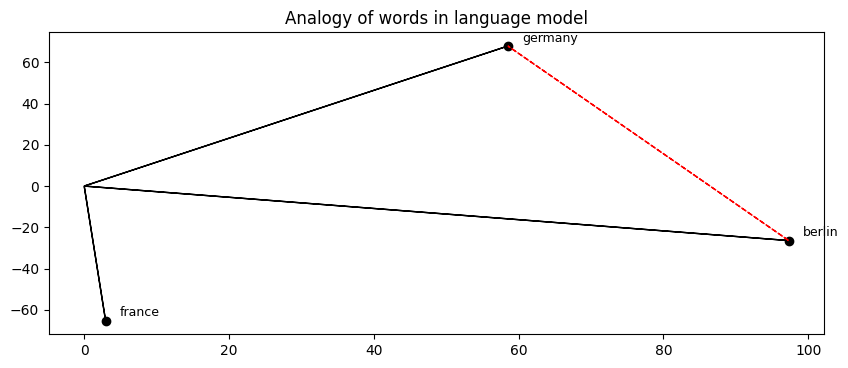

In [16]:
plt.figure(figsize=(10, 4), dpi=100)

for i in range(3):
    vec = vectors[i]
    word = words[i]
    plot_arrow(vec)
    plt.scatter(vec[0], vec[1], color='black')
    plt.text(vec[0]+offset, vec[1]+offset, word, fontsize=9)

plot_arrow(u, v, color='red', ls='--')

plt.title('Analogy of words in language model')
plt.show()

On the image above, we can see a 2D representation for the words germany, and france and paris as well as the difference between germany and berlin (in red). Below you can see how we get a vector similar to paris if we deslocate the diference between germany and berlin to france.

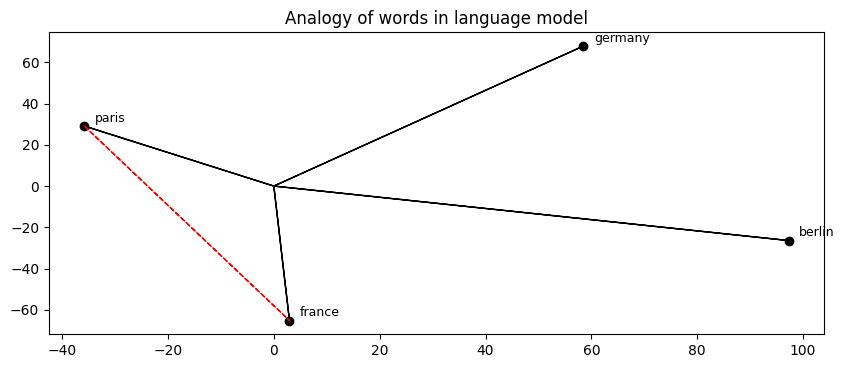

In [17]:
plt.figure(figsize=(10, 4), dpi=100)

for i in range(4):
    vec = vectors[i]
    word = words[i]
    plot_arrow(vec)
    plt.scatter(vec[0], vec[1], color='black')
    plt.text(vec[0]+offset, vec[1]+offset, word, fontsize=9)

plot_arrow(w, (u-v+w), color='red', ls='--')

plt.title('Analogy of words in language model')
plt.show()

You can verify that this behaviour is reproducted for every analog term.

In [18]:
def plot_analogies(model, words):
    vectors = plane_projection(model, words)
    
    for i in range(0, len(words), 2):
        u, v = vectors[i:i+2]
        plot_arrow(u, v)
        plt.scatter(u[0], u[1], color='black')
        plt.text(u[0]+offset, u[1]+offset, words[i], fontsize=9)
        
        plt.scatter(v[0], v[1], color='black')
        plt.text(v[0]+offset, v[1]+offset, words[i+1], fontsize=9)

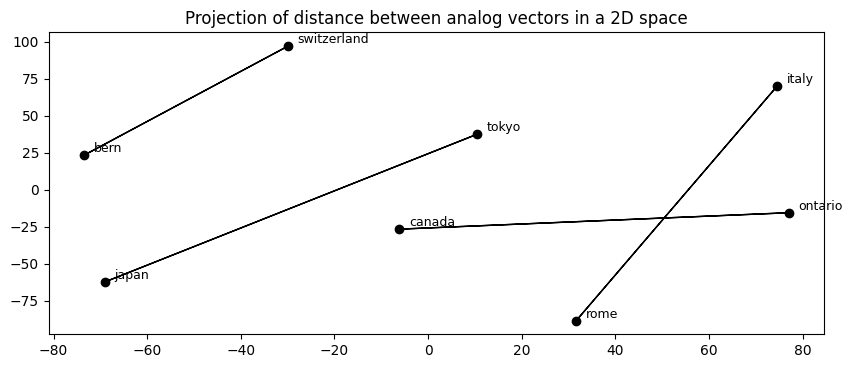

In [19]:
plt.figure(figsize=(10, 4), dpi=100)
plot_analogies(model, [
    'italy', 'rome',
    'japan', 'tokyo',
    'canada', 'ontario',
    'switzerland', 'bern'
])
plt.title('Projection of distance between analog vectors in a 2D space')
plt.show()

Although we have some divergence on a few cases like canada/ontario, this is mostly due to the fact that we are projecting a 300-dimensional vector on a plane.

We can use this caracteristic to measure the accuracy of our model. Given a collection of pre stablished analogies, we will provide the first three words and search the model's reponse for the fourth. Keep in mind that the output of the model is not a single word as the exemples above, it is an array of probabilities, and each component of the array will be accounted for during the accuracy measure, this will also be done by gensim.

In [20]:
# Download test analogies
analogies_uri = 'https://raw.githubusercontent.com/nicholas-leonard/word2vec/master/questions-words.txt'
analogies_file_name = 'questions-words.txt'

if not path.exists(analogies_file_name):
    try:
        resp = urlopen(analogies_uri)
        file = open(analogies_file_name, 'wb')
        file.write(resp.read())
        file.close()
    except:
        if path.exists(analogies_file_name):
            remove(analogies_uri)

In [21]:
def test_model(sg, window, vector_size, epochs, corpus_size, min_count):
    model = get_model(corpus_size, sg, window, vector_size, epochs, min_count)
    analogy_scores = model.evaluate_word_analogies(datapath(analogies_file_name))
    return analogy_scores[0]

The following script will be renspondible for performing the test for each model and saving the results to a dataframe, it even has a nice progress bar. This also takes quite a lot of time, so we will save the dataframes to a csv file so we can load it later.

In [22]:
def test_models(params, results_file_name='accuracy.csv'):
    accuracy_df = pd.DataFrame(columns=['algorithm', 'window', 'vector size', 'epochs', 'corpus size', 'min count', 'accuracy'])

    if not path.exists(results_file_name):
        total = len(params)

        # Skipgram
        done = 0
        print('Skipgram test progress:')
        progress_bar(done, total)
        for param in params:
            try:
                accuracy = test_model(sg=1, window=param[0], vector_size=param[1], epochs=param[2], corpus_size=param[3], min_count=param[4])
                data = {
                    'algorithm': 'skipgram',
                    'window': param[0],
                    'vector size': param[1],
                    'epochs': param[2],
                    'corpus size': param[3],
                    'min count': param[4],
                    'accuracy': accuracy
                }
                accuracy_df = accuracy_df.append(data, ignore_index=True)
            except KeyError:
                pass
            
            done = done + 1
            progress_bar(done, total)
        print('')

        # Cbow
        done = 0
        print('Cbow test progress:')
        progress_bar(done, total)
        for param in params:
            try:
                accuracy = test_model(sg=0, window=param[0], vector_size=param[1], epochs=param[2], corpus_size=param[3], min_count=param[4])
                data = {
                    'algorithm': 'cbow',
                    'window': param[0],
                    'vector size': param[1],
                    'epochs': param[2],
                    'corpus size': param[3],
                    'min count': param[4],
                    'accuracy': accuracy
                }
                accuracy_df = accuracy_df.append(data, ignore_index=True)
            except KeyError:
                pass
            
            done = done + 1
            progress_bar(done, total)

        # Save results
        results_file = open(results_file_name, 'w')
        results_file.write(accuracy_df.to_csv())
        results_file.close()
    else:
        accuracy_df = pd.read_csv(results_file_name, index_col=[0])
        
    return accuracy_df

In [23]:
accuracy_df = test_models(params)
accuracy_df

,algorithm,window,vector size,epochs,corpus size,min count,accuracy
0,skipgram,2,50,10,850,10,0.019171
1,skipgram,2,50,10,850,30,0.027940
2,skipgram,2,50,10,850,50,0.033333
3,skipgram,2,50,10,1701,10,0.022657
4,skipgram,2,50,10,1701,30,0.031580
...,...,...,...,...,...,...,...
211,cbow,10,300,30,850,30,0.105843
212,cbow,10,300,30,850,50,0.126645
213,cbow,10,300,30,1701,10,0.078750
214,cbow,10,300,30,1701,30,0.110575


You can see below the best achieved results for each algorithm. Skipgram had a maximum of 36.8% of accuracy rate while cbow only achieved about 13.8% accuracy.

In [24]:
print('Skipgram:')
skigram_group = accuracy_df[accuracy_df.algorithm == 'skipgram']
print('Max accuracy: {}\tAverage accuracy: {}\n'.format(skigram_group.accuracy.max(), skigram_group.accuracy.mean()))

print('Cbow:')
cbow_group = accuracy_df[accuracy_df.algorithm == 'cbow']
print('Max accuracy: {}\tAverage accuracy: {}\n'.format(cbow_group.accuracy.max(), cbow_group.accuracy.mean()))

Skipgram:
Max accuracy: 0.3687162891046386	Average accuracy: 0.14994445909248685

Cbow:
Max accuracy: 0.1382955771305286	Average accuracy: 0.052833369841598594



## Hyperparameter study

With our accuracy data gathered, we can visualize how each paremeter affected the average accuracy obtained on the figures below.

In [25]:
def plot_influence(param, dataframe):
    skipgram_data = dataframe[dataframe.algorithm == 'skipgram'].groupby(param).mean()
    cbow_data = dataframe[dataframe.algorithm == 'cbow'].groupby(param).mean()
    
    plt.title('Influence of {} in model accuracy'.format(param))
    plt.xlabel(param)
    plt.ylabel('accuracy')
    plt.plot(cbow_data['accuracy'], label='cbow')
    plt.scatter(x=dataframe[param].unique(), y=cbow_data['accuracy'])
    plt.plot(skipgram_data['accuracy'], label='skipgram', color='red')
    plt.scatter(x=dataframe[param].unique(), y=skipgram_data['accuracy'], color='red')
    plt.legend()
    
def parameter_variance(params, dataframe):
    data = pd.DataFrame(columns=['param', 'variance'])
    
    plt.title('Variance of accuracy for each parameter')
    plt.ylabel('accuracy')
    for param in params:
        group = dataframe.groupby(param).mean()
        variance = group['accuracy'].var()
        data = data.append({'param': param, 'variance': variance}, ignore_index=True)
        
    plt.bar(range(len(params)), data['variance'], tick_label=params)

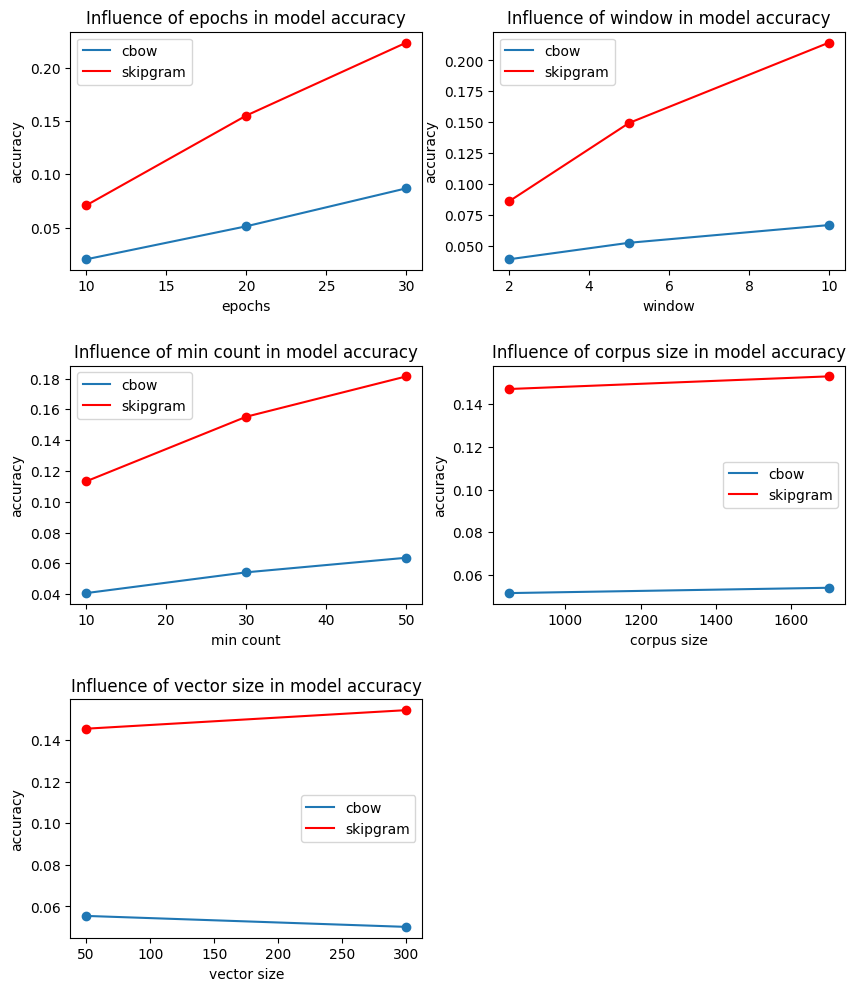

In [26]:
plt.figure(figsize=(10, 12), dpi=100)
params = ['epochs', 'window', 'min count', 'corpus size', 'vector size']

for i in range(len(params)):
    plt.subplot(3, 2, i+1)
    plot_influence(params[i], accuracy_df)
    
plt.subplots_adjust(hspace = .4)
plt.show()

plt.show()

As we can see, for both algorithms the number of the epochs, the size of the context window and the min count had a much greater impact in overall accuracy, while vector size and corpus size created a smaller variation on the results. We can comprove this tendency with the following plot of the variance for each parameter.

Moreover, as the vector size increases, the average accuracy decreases for the cbow algorithm. This could be an indicator of overfitting, as we try to extreact a large number of features from a limited corpus.

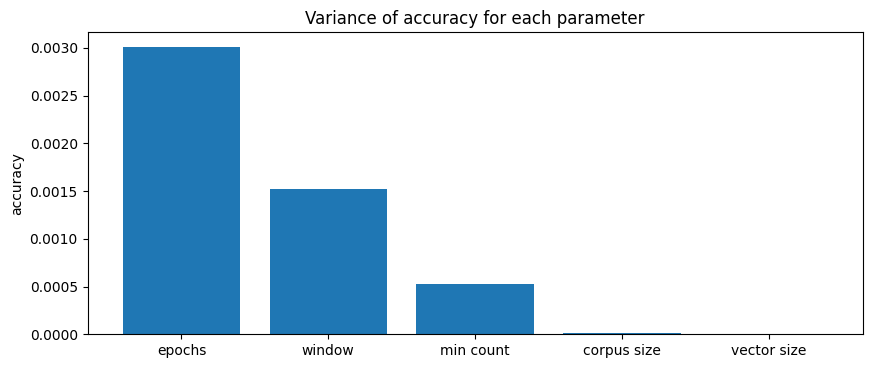

In [27]:
plt.figure(figsize=(10, 4), dpi=100)
parameter_variance(params, accuracy_df)
plt.show()

With this data, we can prioritize the variation of the most relevant params and set a constant value for the remaining ones.

For the skipgram algorithm, we will use a vector size of 100 and our entire corpus while using values between 30 and 70 for the min count, 20 and 60 for the number of epochs and 5 and 10 for window sizes. We will do the same for the cbow algorithm, except we will use 50 for vector size instead of 100, since it gave us a beter accuracy.

In [28]:
vector_sizes = [100]
windows = [5, 10]
min_counts = [30, 50, 70]
corpus_sizes = [len(sentences)]
epochs = [20, 30, 60]
skipgram_params = [list(i) for i in itertools.product(windows, vector_sizes, epochs, corpus_sizes, min_counts)]

train_with_params(sentences, 1, skipgram_params)

Training skipgram models:
[====================] 100%
Took 0 hours and 0 minutes to make 18 skipgram models


In [29]:
vector_sizes = [50]
windows = [5, 10]
min_counts = [30, 50, 70]
corpus_sizes = [len(sentences)]
epochs = [20, 30, 60]
cbow_params = [list(i) for i in itertools.product(windows, vector_sizes, epochs, corpus_sizes, min_counts)]

train_with_params(sentences, 0, cbow_params)

Training cbow models:
[====================] 100%
Took 0 hours and 0 minutes to make 18 cbow models


Now lets see how this changes our obtained maximum and average accuracy:

In [30]:
skipgram_df = test_models(skipgram_params, 'accuracy-skipgram.csv')
skipgram_df = skipgram_df.drop(skipgram_df[skipgram_df.algorithm == 'cbow'].index)

skipgram_df

,algorithm,window,vector size,epochs,corpus size,min count,accuracy
0,skipgram,5,100,20,1701,30,0.177921
1,skipgram,5,100,20,1701,50,0.205825
2,skipgram,5,100,20,1701,70,0.242788
3,skipgram,5,100,30,1701,30,0.249090
4,skipgram,5,100,30,1701,50,0.290076
5,skipgram,5,100,30,1701,70,0.334739
6,skipgram,5,100,60,1701,30,0.354478
7,skipgram,5,100,60,1701,50,0.407659
8,skipgram,5,100,60,1701,70,0.449084
9,skipgram,10,100,20,1701,30,0.250546


In [31]:
cbow_df = test_models(cbow_params, 'accuracy-cbow.csv')
cbow_df = cbow_df.drop(cbow_df[cbow_df.algorithm == 'skipgram'].index)

cbow_df

,algorithm,window,vector size,epochs,corpus size,min count,accuracy
8,cbow,5,50,20,1701,30,0.056516
9,cbow,5,50,20,1701,50,0.066235
10,cbow,5,50,20,1701,70,0.075748
11,cbow,5,50,30,1701,30,0.095650
12,cbow,5,50,30,1701,50,0.112513
13,cbow,5,50,30,1701,70,0.131076
14,cbow,5,50,60,1701,30,0.195759
15,cbow,5,50,60,1701,50,0.232039
16,cbow,5,50,60,1701,70,0.264392
17,cbow,10,50,20,1701,30,0.074536


In [32]:
print('Skipgram:')
print('Max accuracy: {} \tAverage accuracy: {}\n'.format(skipgram_df.accuracy.max(), skipgram_df.accuracy.mean()))

print('Cbow:')
print('Max accuracy: {}\tAverage accuracy: {}\n'.format(cbow_df.accuracy.max(), cbow_df.accuracy.mean()))

Skipgram:
Max accuracy: 0.488209722039257 	Average accuracy: 0.3329544049317867

Cbow:
Max accuracy: 0.2974575154788565	Average accuracy: 0.15081077725330802



Now that we know which hyperparameters to tune, not only we got a much faster training, but we also got a hgher average and maximum accuracy. Now all one got to do is to choose which values will better suit each use case. A higher min count will lead to more recise results at the cost of a smaller vocabulary, so some words that are recognized at min_count = 10 could not exist at min_count = 70. In the example below, ou can see how the word feline is present in model A, but is not in model B, so adjust your min count properly according to your corpus size.

In [39]:
build_if_not_exists(sentences, corpus_size = len(sentences), sg=1, window=10, vector_size=100, epochs=10, min_count=10)
build_if_not_exists(sentences, corpus_size = len(sentences), sg=1, window=10, vector_size=100, epochs=10, min_count=70)

model_a = get_model(corpus_size=len(sentences), sg=1, window=10, vector_size=100, epochs=10, min_count=10)
model_b = get_model(corpus_size=len(sentences), sg=1, window=10, vector_size=100, epochs=10, min_count=70)

word = 'feline'

print('Model A: {}'.format(model_a.most_similar(word)[0][0]))

try:
    print('Model B: {}'.format(model_b.most_similar(word)[0][0]))
    print()
except KeyError:
    print('Model B: feline is not present :(')

Model A: felines
Model B: feline is not present :(


We could also see how a large vector size can cause overfiting on a smaller corpus especially when using cbow, and how a larger number of epochs can increase accuracy but it also makes training slower.